In [304]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import plotly.graph_objects as go
import random

np.random.seed(0)

### Test file for the implementation of the exact couting (=without sampling the input space)
In https://arxiv.org/pdf/1901.09021, section 3.3, they claim to have another way to count the number of regions exactly, without sampling the input space. They are therefore able to count the regions exactly.  
Their method is developed in https://arxiv.org/pdf/1906.00904, in Appendix A, the guys are smart af.

### Next steps:
- Do we really win something by using convex hulls, since in the end we only need the vertices? It is probably haevy to store. If only using vertices then need to be careful about the order. Because when defining the simplices, the order matters. Choose a convention (counterclockwise) and stick to it.
- Test edge cases : What if a line is parallel? What if some of the vertices have sign 0? What if no intersection within this region?
- Extend this for lines through input space instead of planes. If you feel fancy extend for subspaces of any dimension.

In [356]:
# Toy MLP : 2D input
class FeedForwardNN2D(torch.nn.Module):
    def __init__(self):
        super(FeedForwardNN2D, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(2, 3))
        self.layers.append(torch.nn.Linear(3, 3))
        self.layers.append(torch.nn.Linear(3, 2))
        self.layers.append(torch.nn.Linear(2, 1))
        self.init_weights_random()

    def init_weights_random(self):
        for layer in self.layers:
            torch.nn.init.normal_(layer.weight)
            torch.nn.init.normal_(layer.bias)

    def forward(self, x):
        activation = []
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
            activation.append( (x > 0).squeeze().int() )

        x = self.layers[-1](x)
        activation = torch.cat(activation, dim=1)
        return x, activation
    
model = FeedForwardNN2D()

### Good old way to count the regions.
We know this one works, so I use it to test the output of the new method.

Number of regions: 15


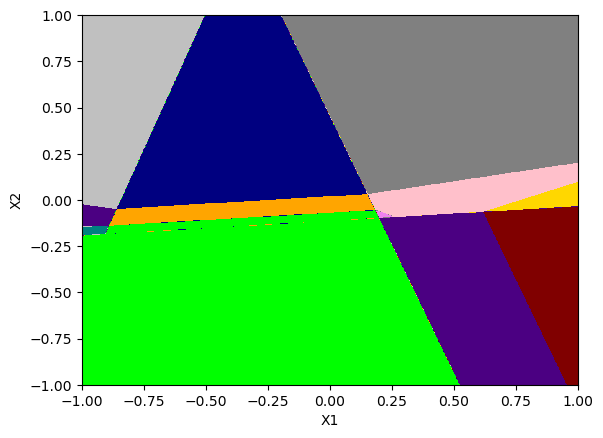

In [357]:
n_samples = 800
boundary = 1
# Sample the input space
X1 = np.linspace(-boundary, boundary, n_samples)
X2 = np.linspace(-boundary, boundary, n_samples)
X1, X2 = np.meshgrid(X1, X2)
X = np.concatenate((X1.reshape(-1, 1), X2.reshape(-1, 1)), axis=1)
X = torch.tensor(X).float().view(n_samples**2, 2)

with torch.no_grad():
    Y, activations = model(X)

unique_activations, inverse_indices = torch.unique(activations, dim=0, return_inverse=True)
print(f"Number of regions: {unique_activations.shape[0]}")
unique_values = torch.unique(inverse_indices).tolist()

# Prepare the plot
color_set = [
        "blue", "green", "yellow", "orange", "red", "purple", "cyan", "magenta",
        "brown", "pink", "lime", "teal", "navy", "gold", "silver", "gray",
        "maroon", "olive", "violet", "indigo"
    ]
color_map = {val: random.choice(color_set) for val in unique_values}

fig = plt.figure()
plt.contourf(
    X1,
    X2,
    inverse_indices.numpy().reshape(n_samples, n_samples),
    colors=[color_map[val] for val in unique_values],
    levels=len(unique_values),
    extend='neither')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### Implementation of the new method

In [358]:
# Geometric utils
def compute_line_segment_intersection(p1, p2, line_coeffs):
    """
    Segment between two points p1, p2: p1 + t * (p2 - p1) with 0 <= t <= 1.
    Line a * x + b * y + c = 0 with line_coeffs: (a, b, c).
    Output: intersection points if it exists, None otherwise.
    """
    x1, y1 = p1
    x2, y2 = p2

    a = line_coeffs[0][0]
    b = line_coeffs[0][1]
    c = line_coeffs[1]

    denominator = a * (x2 - x1) + b * (y2 - y1)
    if abs(denominator) < 1e-9:  # Parallel line    TODO: Check if the segment is on the line?
        return None

    t = -(a * x1 + b * y1 + c) / denominator
    if 0 <= t <= 1:              # Check if intersection is within the segment
        return (x1 + t * (x2 - x1), y1 + t * (y2 - y1))
    return None

def compute_line_region_intersection(convex_hull, line_coeffs):
    """
    convex_hull: scipy.spatial.ConvexHull object.
    line_coeffs: (a, b, c), defining the line a * x + b * y + c = 0.
    Output: list of intersection points.
    """
    intersections = []
    points = convex_hull.points
    for edge in convex_hull.simplices:
        p1, p2 = points[edge[0]], points[edge[1]]
        point = compute_line_segment_intersection(p1, p2, line_coeffs)
        if point is not None:
            intersections.append(point)
    return intersections

# Definition of main object: the region
class ActivationRegion():
    def __init__(self, vertices, activation_pattern, linear_map):
        self.convex_hull = ConvexHull(vertices)     # TODO: Might be an overkill? Just need the vertices
        self.activation_pattern = activation_pattern
        self.linear_map = linear_map

    def update_linear_map(self, W, b):
        A, c = self.linear_map
        a = self.activation_pattern
        A_new = a * W @ A
        c_new = a * W @ c + a * b.view(-1, 1)
        self.linear_map = (A_new, c_new)

# Utils for the counting
def set_empty_activation_pattern(regions, n_neurons):
    for region in regions:
        region.activation_pattern = torch.empty((n_neurons, 1), dtype=torch.float32)

def update_linear_maps(regions, W, b):
    for region in regions:
        region.update_linear_map(W, b)

In [359]:
n_in = model.layers[0].weight.shape[1]
layers = model.layers

init_region = ActivationRegion(
    vertices=np.array([[-1, -1], [-1, 1], [1, 1], [1, -1]]),
    activation_pattern=torch.empty((n_in, 1), dtype=torch.float32),
    linear_map=(torch.eye(n_in), torch.zeros(n_in, 1))
)

regions = [init_region]
with torch.no_grad():
    for l in range(len(layers)-1):      # Iterate over hidden layers
        W = layers[l].weight            # TODO: Currently W, b requires grad. Faster if not?
        b = layers[l].bias
        n_neurons = W.shape[0]
        set_empty_activation_pattern(regions, n_neurons)
        for i in range(n_neurons):      # Iterate over neurons of current layer
            Wi = W[i]
            bi = b[i]
            new_regions = []
            idx_to_remove = []
            for idx, region in enumerate(regions):      # Iterate over regions
                old_activation_pattern = region.activation_pattern
                A, c = region.linear_map
                vertices = region.convex_hull.points[region.convex_hull.vertices]
                input = torch.tensor(vertices, dtype=torch.float32).T
                preactivation = Wi @ (A @ input + c) + bi
                sign = torch.sign(preactivation)

                if torch.unique(sign).shape[0] > 1:     # Region is cut
                    intersection  = compute_line_region_intersection(region.convex_hull, line_coeffs=(Wi @ A, (Wi @ c).squeeze() + bi))
                    if len(intersection) > 0:           # TODO: Necessary? Imo this is useless, the region IS cut.
                        idx_to_remove.append(idx)
                        new_vertices = np.concatenate((vertices[np.where(sign > 0)[0]], intersection), axis=0)
                        new_activation_pattern = old_activation_pattern.clone()
                        new_activation_pattern[i] = 1
                        new_region = ActivationRegion(
                            vertices=new_vertices,
                            activation_pattern=new_activation_pattern,
                            linear_map=(A, c)
                        )
                        new_regions.append(new_region)

                        new_vertices = np.concatenate((vertices[np.where(sign < 0)[0]], intersection), axis=0)
                        new_activation_pattern = old_activation_pattern.clone()
                        new_activation_pattern[i] = 0
                        new_region = ActivationRegion(
                            vertices=new_vertices,
                            activation_pattern=new_activation_pattern,
                            linear_map=(A, c)
                        )
                        new_regions.append(new_region)
                else:                                   # Region is not cut
                    if sign[0] == 1:                    # TODO: Find cleaner way to do this
                        new_activation_pattern = old_activation_pattern.clone()
                        new_activation_pattern[i] = 1
                        region.activation_pattern = new_activation_pattern
                    else:
                        new_activation_pattern = old_activation_pattern.clone()
                        new_activation_pattern[i] = 0
                        region.activation_pattern = new_activation_pattern
            regions = [region for idx, region in enumerate(regions) if idx not in idx_to_remove]   # TODO: Find a cleaner way
            regions.extend(new_regions)

        # Update the linear maps of the regions
        update_linear_maps(regions, W, b)

15


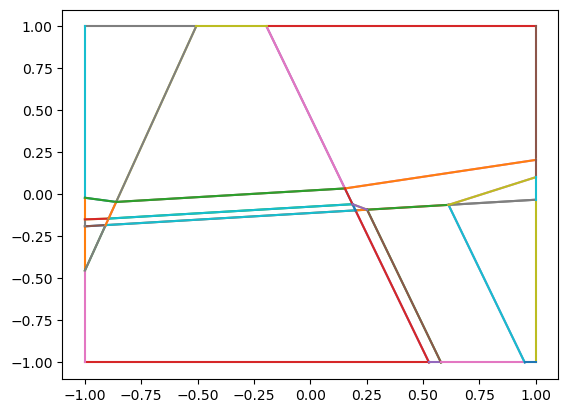

In [360]:
print(len(regions))
for region in regions:
    for simplex in region.convex_hull.simplices:
        plt.plot(region.convex_hull.points[simplex, 0], region.convex_hull.points[simplex, 1])

In [361]:
# Plot the regions in different subplots. Was useful for debugging.

"""
print(len(regions))
fig, ax = plt.subplots(1, len(regions)+1, figsize=(20, 5))
colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k', 'w', 'orange', 'purple', 'brown', 'pink', 'gray']
ax[0].set_xlim(-1.1, 1.1)
ax[0].set_ylim(-1.1, 1.1)
for i, region in enumerate(regions):
    for simplex in region.convex_hull.simplices:
        ax[i+1].plot(region.convex_hull.points[simplex, 0], region.convex_hull.points[simplex, 1], "k-", lw=1)
        ax[i+1].set_xlim(-1.1, 1.1)
        ax[i+1].set_ylim(-1.1, 1.1)
        ax[0].plot(region.convex_hull.points[simplex, 0], region.convex_hull.points[simplex, 1], colors[i])

plt.tight_layout()
plt.show()
"""

'\nprint(len(regions))\nfig, ax = plt.subplots(1, len(regions)+1, figsize=(20, 5))\ncolors = [\'r\', \'b\', \'g\', \'y\', \'m\', \'c\', \'k\', \'w\', \'orange\', \'purple\', \'brown\', \'pink\', \'gray\']\nax[0].set_xlim(-1.1, 1.1)\nax[0].set_ylim(-1.1, 1.1)\nfor i, region in enumerate(regions):\n    for simplex in region.convex_hull.simplices:\n        ax[i+1].plot(region.convex_hull.points[simplex, 0], region.convex_hull.points[simplex, 1], "k-", lw=1)\n        ax[i+1].set_xlim(-1.1, 1.1)\n        ax[i+1].set_ylim(-1.1, 1.1)\n        ax[0].plot(region.convex_hull.points[simplex, 0], region.convex_hull.points[simplex, 1], colors[i])\n\nplt.tight_layout()\nplt.show()\n'